https://www.kaggle.com/code/greatcodes/pytorch-cnn-resnet18-cifar10/notebook

https://pytorch-tutorial.readthedocs.io/en/latest/tutorial/chapter03_intermediate/3_2_2_cnn_resnet_cifar10/

In [28]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
# Importing Libraries
import os
import copy
import random
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

import matplotlib.pyplot as plt
%matplotlib inline

SEED = 1234

device = "cuda" if torch.cuda.is_available else "cpu"
print(device)

cuda


In [30]:
from torchvision import transforms
import numpy as np
import torch

# Returns a list of transformations when called

class GetTransforms():
    '''Returns a list of transformations when type as requested amongst train/test
       Transforms('train') = list of transforms to apply on training data
       Transforms('test') = list of transforms to apply on testing data'''

    def __init__(self):
        pass

    def trainparams(self):
        train_transformations = [ #resises the image so it can be perfect for our model.
            transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
            transforms.RandomRotation((-7,7)),     #Rotates the image to a specified angel
            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
            transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)) #Normalize all the images
            ]

        return train_transformations

    def testparams(self):
        test_transforms = [
            transforms.ToTensor(),
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261))
        ]
        return test_transforms

In [31]:
from torchvision import datasets
from torchvision import transforms


transformations = GetTransforms()
train_transforms = transforms.Compose(transformations.trainparams())
test_transforms = transforms.Compose(transformations.testparams())


class GetCIFAR10_TrainData():
    def __init__(self, dir_name:str):
        self.dirname = dir_name

    def download_train_data(self):
        return datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)

    def download_test_data(self):
        return datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)


In [32]:
cdata = GetCIFAR10_TrainData(os.chdir(".."))
trainset = cdata.download_train_data()
testset = cdata.download_test_data()

VALID_RATIO = 0.9
n_train_examples = int(len(trainset) * VALID_RATIO)
n_valid_examples = len(trainset) - n_train_examples

trainset, validset = data.random_split(trainset, 
                                           [n_train_examples, n_valid_examples])

validset = copy.deepcopy(validset)
validset.dataset.transform = test_transforms

Files already downloaded and verified
Files already downloaded and verified


In [33]:
len(trainset), len(validset), len(testset)

(45000, 5000, 10000)

In [34]:
BATCH_SIZE = 512

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

# The Model - RESNET18


In [35]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

In [36]:
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.dropout1 = nn.Dropout(0.1)
        
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout(0.1)
        
        self.downsample = downsample

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.dropout1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.dropout2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        
        self.in_channels = 64
        
        self.conv = conv3x3(in_channels=3, out_channels=64)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self.make_layer(block=block, out_channels=64, blocks=layers[0], stride=1)
        self.layer2 = self.make_layer(block=block, out_channels=128, blocks=layers[1], stride=2)
        self.layer3 = self.make_layer(block=block, out_channels=256, blocks=layers[2], stride=2)
        # self.layer4 = self.make_layer(block=block, out_channels=512, blocks=layers[3], stride=2)

        self.avg_pool = nn.AvgPool2d(4)
        # self.fc = nn.Linear(256, num_classes)
        self.fc = nn.Linear(1024, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return F.log_softmax(out, dim=-1)

def ResNet18():
    # return ResNet(ResidualBlock, [2, 2, 2, 2])
    return ResNet(ResidualBlock, [3, 4, 3])

In [37]:
# Importing Model and printing Summary
model = ResNet18().to(device)
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
           Dropout-6           [-1, 64, 32, 32]               0
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
          Dropout-10           [-1, 64, 32, 32]               0
             ReLU-11           [-1, 64, 32, 32]               0
    ResidualBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [38]:
from tqdm import tqdm
from torch import nn
import torch.nn
from torch.functional import F
import os


def model_training(model, device, train_dataloader, optimizer, train_acc, train_losses):
            
    model.train()
    pbar = tqdm(train_dataloader)
    correct = 0
    processed = 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, target)
        

        # train_losses.append(loss.item())
        loss.backward()
        optimizer.step()

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        
        # print statistics
        
        running_loss += loss.item()
        pbar.set_description(desc=f'Batch_id={batch_idx} Batch Loss={loss.item()} Running Loss={running_loss} Running Accuracy={100*correct/processed:0.2f}')
        # train_acc.append(100*correct/processed)
    
    train_losses.append(running_loss)
    train_acc.append(100*correct/processed)

In [39]:
import torch
import os
from torch.functional import F

cwd = os.getcwd()

def model_testing(model, device, test_dataloader, test_acc, test_losses, misclassified = []):
    
    model.eval()
    test_loss = 0
    correct = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    # label = 0
    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    with torch.no_grad():

        for index, (data, target) in enumerate(test_dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            
            for d,i,j in zip(data, pred, target):
                if i != j:
                    misclassified.append([d.cpu(),i[0].cpu(),j.cpu()])

            test_loss += F.nll_loss(output, target, reduction='sum').item()
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))
    
    test_acc.append(100. * correct / len(test_dataloader.dataset))
    return misclassified, correct / len(test_dataloader.dataset)

In [40]:
def model_evaluation(model, device, loader):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in loader:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = F.nll_loss(y_pred, y)
        
            pred = y_pred.argmax(dim=1, keepdim=True)
            acc = pred.eq(y.view_as(pred)).sum()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    epoch_loss / len(loader.dataset), epoch_acc, len(loader.dataset),
    100. * epoch_acc / len(loader.dataset)))

    return epoch_loss, epoch_acc / len(loader.dataset)

In [41]:
# Defining parameters

criterion = nn.CrossEntropyLoss()

# optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, threshold=0.000001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
# scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

In [42]:
import pandas

def save_to_csv(train_losses, train_accs, test_losses, test_accs):
  df = pandas.DataFrame()
  df["epoch"] = [i+1 for i in range(len(train_losses))]
  df["train_loss"] = train_losses
  df["test_loss"] = test_losses
  df["train_acc"] = train_accs
  df["test_acc"] = test_accs
  df.to_csv("15_resnet_3_4_3_inchannels_64_dropout_less_threshold.csv")

In [43]:
# Training the model

train_acc = []
train_losses = []
valid_accs = []
valid_losses = []
test_acc = []
test_losses = []
min_valid_loss = None
max_acc = None

EPOCHS = 120

for i in range(EPOCHS):
    print(f'EPOCHS : {i}')
    model_training(model, device, trainloader, optimizer, train_acc, train_losses)

    # Validating the model for the current epoch
    valid_loss, valid_acc = model_evaluation(model, device, validloader)  

    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    if not min_valid_loss:
      min_valid_loss = valid_loss
    else:
      if valid_loss < min_valid_loss:
        min_valid_loss = valid_loss
        torch.save(model, "best_model.pickle")

    # scheduler.step(train_losses[-1])
    scheduler.step(valid_loss)

    misclassified, test_acc2 = model_testing(model, device, testloader, test_acc, test_losses)

    if not max_acc:
      max_acc = test_acc2
    else:
      if test_acc2 > max_acc:
        max_acc = test_acc2
        torch.save(model, "best_test_acc_model.pickle")

    save_to_csv(train_losses, train_acc, test_losses, test_acc)


EPOCHS : 0


Batch_id=87 Batch Loss=1.394409418106079 Running Loss=153.83130073547363 Running Accuracy=35.43: 100%|██████████| 88/88 [00:19<00:00,  4.62it/s]



Validation set: Average loss: 0.0032, Accuracy: 2277/5000 (45.54%)


Test set: Average loss: 1.5787, Accuracy: 4449/10000 (44.49%)

EPOCHS : 1


Batch_id=87 Batch Loss=1.0621992349624634 Running Loss=113.21879601478577 Running Accuracy=53.42: 100%|██████████| 88/88 [00:19<00:00,  4.47it/s]



Validation set: Average loss: 0.0026, Accuracy: 2934/5000 (58.68%)


Test set: Average loss: 1.3010, Accuracy: 5867/10000 (58.67%)

EPOCHS : 2


Batch_id=87 Batch Loss=1.091835618019104 Running Loss=92.95577090978622 Running Accuracy=62.32: 100%|██████████| 88/88 [00:18<00:00,  4.74it/s]



Validation set: Average loss: 0.0017, Accuracy: 3504/5000 (70.08%)


Test set: Average loss: 0.8807, Accuracy: 6942/10000 (69.42%)

EPOCHS : 3


Batch_id=87 Batch Loss=0.9130333065986633 Running Loss=79.93937581777573 Running Accuracy=67.74: 100%|██████████| 88/88 [00:18<00:00,  4.79it/s]



Validation set: Average loss: 0.0020, Accuracy: 3443/5000 (68.86%)


Test set: Average loss: 0.9961, Accuracy: 6879/10000 (68.79%)

EPOCHS : 4


Batch_id=87 Batch Loss=0.7643350958824158 Running Loss=71.24460542201996 Running Accuracy=71.45: 100%|██████████| 88/88 [00:18<00:00,  4.81it/s]



Validation set: Average loss: 0.0016, Accuracy: 3586/5000 (71.72%)


Test set: Average loss: 0.8321, Accuracy: 7104/10000 (71.04%)

EPOCHS : 5


Batch_id=87 Batch Loss=0.7250975966453552 Running Loss=64.98948776721954 Running Accuracy=74.06: 100%|██████████| 88/88 [00:18<00:00,  4.82it/s]



Validation set: Average loss: 0.0014, Accuracy: 3804/5000 (76.08%)


Test set: Average loss: 0.7252, Accuracy: 7628/10000 (76.28%)

EPOCHS : 6


Batch_id=87 Batch Loss=0.7538983821868896 Running Loss=60.12780547142029 Running Accuracy=76.16: 100%|██████████| 88/88 [00:18<00:00,  4.82it/s]



Validation set: Average loss: 0.0012, Accuracy: 3953/5000 (79.06%)


Test set: Average loss: 0.6249, Accuracy: 7898/10000 (78.98%)

EPOCHS : 7


Batch_id=87 Batch Loss=0.5530636310577393 Running Loss=56.00776672363281 Running Accuracy=77.61: 100%|██████████| 88/88 [00:18<00:00,  4.83it/s]



Validation set: Average loss: 0.0011, Accuracy: 4039/5000 (80.78%)


Test set: Average loss: 0.5793, Accuracy: 8105/10000 (81.05%)

EPOCHS : 8


Batch_id=87 Batch Loss=0.6178332567214966 Running Loss=53.035459369421005 Running Accuracy=79.00: 100%|██████████| 88/88 [00:18<00:00,  4.78it/s]



Validation set: Average loss: 0.0012, Accuracy: 4001/5000 (80.02%)


Test set: Average loss: 0.6243, Accuracy: 8021/10000 (80.21%)

EPOCHS : 9


Batch_id=87 Batch Loss=0.46059882640838623 Running Loss=49.52492159605026 Running Accuracy=80.42: 100%|██████████| 88/88 [00:18<00:00,  4.84it/s]



Validation set: Average loss: 0.0012, Accuracy: 4009/5000 (80.18%)


Test set: Average loss: 0.6013, Accuracy: 7991/10000 (79.91%)

EPOCHS : 10


Batch_id=87 Batch Loss=0.6064427495002747 Running Loss=47.23144271969795 Running Accuracy=81.30: 100%|██████████| 88/88 [00:18<00:00,  4.73it/s]



Validation set: Average loss: 0.0015, Accuracy: 3808/5000 (76.16%)


Test set: Average loss: 0.7813, Accuracy: 7574/10000 (75.74%)

EPOCHS : 11


Batch_id=87 Batch Loss=0.5092248916625977 Running Loss=45.25657653808594 Running Accuracy=81.99: 100%|██████████| 88/88 [00:18<00:00,  4.77it/s]



Validation set: Average loss: 0.0011, Accuracy: 4083/5000 (81.66%)


Test set: Average loss: 0.5551, Accuracy: 8151/10000 (81.51%)

EPOCHS : 12


Batch_id=87 Batch Loss=0.44105264544487 Running Loss=43.3693765103817 Running Accuracy=82.59: 100%|██████████| 88/88 [00:18<00:00,  4.70it/s]



Validation set: Average loss: 0.0010, Accuracy: 4178/5000 (83.56%)


Test set: Average loss: 0.4885, Accuracy: 8322/10000 (83.22%)

EPOCHS : 13


Batch_id=87 Batch Loss=0.496237576007843 Running Loss=40.93591606616974 Running Accuracy=83.88: 100%|██████████| 88/88 [00:18<00:00,  4.80it/s]



Validation set: Average loss: 0.0010, Accuracy: 4173/5000 (83.46%)


Test set: Average loss: 0.5381, Accuracy: 8259/10000 (82.59%)

EPOCHS : 14


Batch_id=87 Batch Loss=0.5100923776626587 Running Loss=39.01284509897232 Running Accuracy=84.54: 100%|██████████| 88/88 [00:18<00:00,  4.74it/s]



Validation set: Average loss: 0.0009, Accuracy: 4244/5000 (84.88%)


Test set: Average loss: 0.4628, Accuracy: 8422/10000 (84.22%)

EPOCHS : 15


Batch_id=87 Batch Loss=0.41033536195755005 Running Loss=37.32903391122818 Running Accuracy=85.22: 100%|██████████| 88/88 [00:18<00:00,  4.73it/s]



Validation set: Average loss: 0.0010, Accuracy: 4189/5000 (83.78%)


Test set: Average loss: 0.5072, Accuracy: 8306/10000 (83.06%)

EPOCHS : 16


Batch_id=87 Batch Loss=0.3606109917163849 Running Loss=36.89750996232033 Running Accuracy=85.09: 100%|██████████| 88/88 [00:18<00:00,  4.83it/s]



Validation set: Average loss: 0.0009, Accuracy: 4286/5000 (85.72%)


Test set: Average loss: 0.4373, Accuracy: 8537/10000 (85.37%)

EPOCHS : 17


Batch_id=87 Batch Loss=0.41053763031959534 Running Loss=35.27106401324272 Running Accuracy=86.04: 100%|██████████| 88/88 [00:18<00:00,  4.82it/s]



Validation set: Average loss: 0.0009, Accuracy: 4297/5000 (85.94%)


Test set: Average loss: 0.4469, Accuracy: 8579/10000 (85.79%)

EPOCHS : 18


Batch_id=87 Batch Loss=0.45922160148620605 Running Loss=34.07129317522049 Running Accuracy=86.47: 100%|██████████| 88/88 [00:18<00:00,  4.81it/s]



Validation set: Average loss: 0.0009, Accuracy: 4287/5000 (85.74%)


Test set: Average loss: 0.4426, Accuracy: 8580/10000 (85.80%)

EPOCHS : 19


Batch_id=87 Batch Loss=0.3226478695869446 Running Loss=32.77491453289986 Running Accuracy=86.79: 100%|██████████| 88/88 [00:18<00:00,  4.76it/s]



Validation set: Average loss: 0.0008, Accuracy: 4349/5000 (86.98%)


Test set: Average loss: 0.4070, Accuracy: 8631/10000 (86.31%)

EPOCHS : 20


Batch_id=87 Batch Loss=0.37144896388053894 Running Loss=32.52258601784706 Running Accuracy=86.96: 100%|██████████| 88/88 [00:18<00:00,  4.71it/s]



Validation set: Average loss: 0.0010, Accuracy: 4155/5000 (83.10%)


Test set: Average loss: 0.5184, Accuracy: 8323/10000 (83.23%)

EPOCHS : 21


Batch_id=87 Batch Loss=0.34801989793777466 Running Loss=31.694481313228607 Running Accuracy=87.33: 100%|██████████| 88/88 [00:18<00:00,  4.83it/s]



Validation set: Average loss: 0.0008, Accuracy: 4329/5000 (86.58%)


Test set: Average loss: 0.4062, Accuracy: 8666/10000 (86.66%)

EPOCHS : 22


Batch_id=87 Batch Loss=0.34280210733413696 Running Loss=29.955935537815094 Running Accuracy=87.98: 100%|██████████| 88/88 [00:18<00:00,  4.82it/s]



Validation set: Average loss: 0.0007, Accuracy: 4378/5000 (87.56%)


Test set: Average loss: 0.3911, Accuracy: 8715/10000 (87.15%)

EPOCHS : 23


Batch_id=87 Batch Loss=0.4308488070964813 Running Loss=29.62902331352234 Running Accuracy=87.99: 100%|██████████| 88/88 [00:18<00:00,  4.80it/s]



Validation set: Average loss: 0.0007, Accuracy: 4414/5000 (88.28%)


Test set: Average loss: 0.3715, Accuracy: 8787/10000 (87.87%)

EPOCHS : 24


Batch_id=87 Batch Loss=0.3036689758300781 Running Loss=28.660184383392334 Running Accuracy=88.43: 100%|██████████| 88/88 [00:18<00:00,  4.78it/s]



Validation set: Average loss: 0.0008, Accuracy: 4367/5000 (87.34%)


Test set: Average loss: 0.4114, Accuracy: 8690/10000 (86.90%)

EPOCHS : 25


Batch_id=87 Batch Loss=0.3103092610836029 Running Loss=27.290302082896233 Running Accuracy=88.98: 100%|██████████| 88/88 [00:18<00:00,  4.71it/s]



Validation set: Average loss: 0.0008, Accuracy: 4390/5000 (87.80%)


Test set: Average loss: 0.3800, Accuracy: 8795/10000 (87.95%)

EPOCHS : 26


Batch_id=87 Batch Loss=0.30807894468307495 Running Loss=27.015054285526276 Running Accuracy=89.14: 100%|██████████| 88/88 [00:18<00:00,  4.76it/s]



Validation set: Average loss: 0.0008, Accuracy: 4400/5000 (88.00%)


Test set: Average loss: 0.4229, Accuracy: 8739/10000 (87.39%)

EPOCHS : 27


Batch_id=87 Batch Loss=0.27131155133247375 Running Loss=25.6864295899868 Running Accuracy=89.59: 100%|██████████| 88/88 [00:18<00:00,  4.82it/s]



Validation set: Average loss: 0.0007, Accuracy: 4426/5000 (88.52%)


Test set: Average loss: 0.3808, Accuracy: 8776/10000 (87.76%)

EPOCHS : 28


Batch_id=87 Batch Loss=0.37055814266204834 Running Loss=24.930638417601585 Running Accuracy=89.94: 100%|██████████| 88/88 [00:18<00:00,  4.85it/s]



Validation set: Average loss: 0.0007, Accuracy: 4448/5000 (88.96%)


Test set: Average loss: 0.3844, Accuracy: 8824/10000 (88.24%)

EPOCHS : 29


Batch_id=87 Batch Loss=0.2705937325954437 Running Loss=24.296891659498215 Running Accuracy=90.21: 100%|██████████| 88/88 [00:18<00:00,  4.81it/s]



Validation set: Average loss: 0.0008, Accuracy: 4407/5000 (88.14%)


Test set: Average loss: 0.3988, Accuracy: 8776/10000 (87.76%)

EPOCHS : 30


Batch_id=87 Batch Loss=0.25241586565971375 Running Loss=23.742034316062927 Running Accuracy=90.28: 100%|██████████| 88/88 [00:18<00:00,  4.82it/s]



Validation set: Average loss: 0.0008, Accuracy: 4396/5000 (87.92%)


Test set: Average loss: 0.4029, Accuracy: 8731/10000 (87.31%)

EPOCHS : 31


Batch_id=87 Batch Loss=0.23201274871826172 Running Loss=22.507474720478058 Running Accuracy=91.05: 100%|██████████| 88/88 [00:18<00:00,  4.82it/s]



Validation set: Average loss: 0.0008, Accuracy: 4418/5000 (88.36%)


Test set: Average loss: 0.3702, Accuracy: 8849/10000 (88.49%)

EPOCHS : 32


Batch_id=87 Batch Loss=0.29201364517211914 Running Loss=22.104596719145775 Running Accuracy=91.10: 100%|██████████| 88/88 [00:18<00:00,  4.84it/s]



Validation set: Average loss: 0.0007, Accuracy: 4434/5000 (88.68%)


Test set: Average loss: 0.3678, Accuracy: 8838/10000 (88.38%)

EPOCHS : 33


Batch_id=87 Batch Loss=0.295394629240036 Running Loss=22.327120378613472 Running Accuracy=91.02: 100%|██████████| 88/88 [00:18<00:00,  4.81it/s]



Validation set: Average loss: 0.0009, Accuracy: 4331/5000 (86.62%)


Test set: Average loss: 0.4437, Accuracy: 8637/10000 (86.37%)

EPOCHS : 34


Batch_id=87 Batch Loss=0.1889123022556305 Running Loss=21.72629414498806 Running Accuracy=91.16: 100%|██████████| 88/88 [00:18<00:00,  4.79it/s]



Validation set: Average loss: 0.0007, Accuracy: 4448/5000 (88.96%)


Test set: Average loss: 0.3766, Accuracy: 8823/10000 (88.23%)

EPOCHS : 35


Batch_id=87 Batch Loss=0.28585559129714966 Running Loss=20.910774618387222 Running Accuracy=91.52: 100%|██████████| 88/88 [00:18<00:00,  4.81it/s]



Validation set: Average loss: 0.0008, Accuracy: 4413/5000 (88.26%)


Test set: Average loss: 0.4004, Accuracy: 8767/10000 (87.67%)

EPOCHS : 36


Batch_id=87 Batch Loss=0.2934291958808899 Running Loss=20.17097383737564 Running Accuracy=91.84: 100%|██████████| 88/88 [00:18<00:00,  4.79it/s]



Validation set: Average loss: 0.0007, Accuracy: 4463/5000 (89.26%)


Test set: Average loss: 0.3619, Accuracy: 8858/10000 (88.58%)

EPOCHS : 37


Batch_id=87 Batch Loss=0.23183439671993256 Running Loss=19.499872535467148 Running Accuracy=92.06: 100%|██████████| 88/88 [00:18<00:00,  4.75it/s]



Validation set: Average loss: 0.0007, Accuracy: 4484/5000 (89.68%)


Test set: Average loss: 0.3397, Accuracy: 8935/10000 (89.35%)

EPOCHS : 38


Batch_id=87 Batch Loss=0.19924360513687134 Running Loss=19.59136226773262 Running Accuracy=92.10: 100%|██████████| 88/88 [00:18<00:00,  4.81it/s]



Validation set: Average loss: 0.0008, Accuracy: 4425/5000 (88.50%)


Test set: Average loss: 0.3834, Accuracy: 8896/10000 (88.96%)

EPOCHS : 39


Batch_id=87 Batch Loss=0.23978467285633087 Running Loss=19.136166751384735 Running Accuracy=92.25: 100%|██████████| 88/88 [00:18<00:00,  4.81it/s]



Validation set: Average loss: 0.0007, Accuracy: 4477/5000 (89.54%)


Test set: Average loss: 0.3567, Accuracy: 8933/10000 (89.33%)

EPOCHS : 40


Batch_id=87 Batch Loss=0.2238294631242752 Running Loss=18.352607920765877 Running Accuracy=92.52: 100%|██████████| 88/88 [00:18<00:00,  4.74it/s]



Validation set: Average loss: 0.0008, Accuracy: 4426/5000 (88.52%)


Test set: Average loss: 0.3938, Accuracy: 8820/10000 (88.20%)

EPOCHS : 41


Batch_id=87 Batch Loss=0.1831735074520111 Running Loss=17.84854218363762 Running Accuracy=92.75: 100%|██████████| 88/88 [00:18<00:00,  4.85it/s]



Validation set: Average loss: 0.0007, Accuracy: 4466/5000 (89.32%)


Test set: Average loss: 0.3681, Accuracy: 8895/10000 (88.95%)

EPOCHS : 42


Batch_id=87 Batch Loss=0.22576241195201874 Running Loss=18.03648369014263 Running Accuracy=92.73: 100%|██████████| 88/88 [00:18<00:00,  4.83it/s]



Validation set: Average loss: 0.0008, Accuracy: 4443/5000 (88.86%)

Epoch 00043: reducing learning rate of group 0 to 1.0000e-03.

Test set: Average loss: 0.3623, Accuracy: 8941/10000 (89.41%)

EPOCHS : 43


Batch_id=87 Batch Loss=0.15141379833221436 Running Loss=13.41411778330803 Running Accuracy=94.66: 100%|██████████| 88/88 [00:18<00:00,  4.79it/s]



Validation set: Average loss: 0.0006, Accuracy: 4550/5000 (91.00%)


Test set: Average loss: 0.2895, Accuracy: 9107/10000 (91.07%)

EPOCHS : 44


Batch_id=87 Batch Loss=0.16070842742919922 Running Loss=11.888747848570347 Running Accuracy=95.45: 100%|██████████| 88/88 [00:18<00:00,  4.75it/s]



Validation set: Average loss: 0.0006, Accuracy: 4552/5000 (91.04%)


Test set: Average loss: 0.2836, Accuracy: 9137/10000 (91.37%)

EPOCHS : 45


Batch_id=87 Batch Loss=0.1112913116812706 Running Loss=11.320376887917519 Running Accuracy=95.64: 100%|██████████| 88/88 [00:18<00:00,  4.78it/s]



Validation set: Average loss: 0.0006, Accuracy: 4583/5000 (91.66%)


Test set: Average loss: 0.2802, Accuracy: 9140/10000 (91.40%)

EPOCHS : 46


Batch_id=87 Batch Loss=0.11348772794008255 Running Loss=11.214193537831306 Running Accuracy=95.72: 100%|██████████| 88/88 [00:18<00:00,  4.77it/s]



Validation set: Average loss: 0.0006, Accuracy: 4576/5000 (91.52%)


Test set: Average loss: 0.2800, Accuracy: 9142/10000 (91.42%)

EPOCHS : 47


Batch_id=87 Batch Loss=0.11446337401866913 Running Loss=10.610692374408245 Running Accuracy=95.90: 100%|██████████| 88/88 [00:18<00:00,  4.70it/s]



Validation set: Average loss: 0.0006, Accuracy: 4575/5000 (91.50%)


Test set: Average loss: 0.2852, Accuracy: 9131/10000 (91.31%)

EPOCHS : 48


Batch_id=87 Batch Loss=0.10052555799484253 Running Loss=10.516863085329533 Running Accuracy=95.93: 100%|██████████| 88/88 [00:18<00:00,  4.80it/s]



Validation set: Average loss: 0.0006, Accuracy: 4562/5000 (91.24%)


Test set: Average loss: 0.2838, Accuracy: 9121/10000 (91.21%)

EPOCHS : 49


Batch_id=87 Batch Loss=0.15729612112045288 Running Loss=10.411546140909195 Running Accuracy=95.97: 100%|██████████| 88/88 [00:18<00:00,  4.70it/s]



Validation set: Average loss: 0.0006, Accuracy: 4576/5000 (91.52%)


Test set: Average loss: 0.2831, Accuracy: 9124/10000 (91.24%)

EPOCHS : 50


Batch_id=87 Batch Loss=0.11942309886217117 Running Loss=10.311774402856827 Running Accuracy=95.92: 100%|██████████| 88/88 [00:18<00:00,  4.79it/s]



Validation set: Average loss: 0.0006, Accuracy: 4574/5000 (91.48%)


Test set: Average loss: 0.2830, Accuracy: 9149/10000 (91.49%)

EPOCHS : 51


Batch_id=87 Batch Loss=0.1093527153134346 Running Loss=10.367651224136353 Running Accuracy=96.00: 100%|██████████| 88/88 [00:18<00:00,  4.77it/s]



Validation set: Average loss: 0.0006, Accuracy: 4582/5000 (91.64%)

Epoch 00052: reducing learning rate of group 0 to 1.0000e-04.

Test set: Average loss: 0.2820, Accuracy: 9146/10000 (91.46%)

EPOCHS : 52


Batch_id=87 Batch Loss=0.09822874516248703 Running Loss=9.986820317804813 Running Accuracy=96.08: 100%|██████████| 88/88 [00:18<00:00,  4.67it/s]



Validation set: Average loss: 0.0006, Accuracy: 4578/5000 (91.56%)


Test set: Average loss: 0.2810, Accuracy: 9153/10000 (91.53%)

EPOCHS : 53


Batch_id=87 Batch Loss=0.12863624095916748 Running Loss=9.605998560786247 Running Accuracy=96.33: 100%|██████████| 88/88 [00:18<00:00,  4.75it/s]



Validation set: Average loss: 0.0006, Accuracy: 4575/5000 (91.50%)


Test set: Average loss: 0.2807, Accuracy: 9153/10000 (91.53%)

EPOCHS : 54


Batch_id=87 Batch Loss=0.100103460252285 Running Loss=9.846237726509571 Running Accuracy=96.09: 100%|██████████| 88/88 [00:18<00:00,  4.78it/s]



Validation set: Average loss: 0.0006, Accuracy: 4579/5000 (91.58%)


Test set: Average loss: 0.2796, Accuracy: 9162/10000 (91.62%)

EPOCHS : 55


Batch_id=87 Batch Loss=0.11577990651130676 Running Loss=10.001863069832325 Running Accuracy=96.20: 100%|██████████| 88/88 [00:18<00:00,  4.77it/s]



Validation set: Average loss: 0.0006, Accuracy: 4577/5000 (91.54%)


Test set: Average loss: 0.2797, Accuracy: 9150/10000 (91.50%)

EPOCHS : 56


Batch_id=87 Batch Loss=0.09426179528236389 Running Loss=9.674910143017769 Running Accuracy=96.28: 100%|██████████| 88/88 [00:18<00:00,  4.75it/s]



Validation set: Average loss: 0.0006, Accuracy: 4570/5000 (91.40%)


Test set: Average loss: 0.2807, Accuracy: 9145/10000 (91.45%)

EPOCHS : 57


Batch_id=87 Batch Loss=0.10294383764266968 Running Loss=9.661841429769993 Running Accuracy=96.31: 100%|██████████| 88/88 [00:18<00:00,  4.80it/s]



Validation set: Average loss: 0.0006, Accuracy: 4571/5000 (91.42%)


Test set: Average loss: 0.2792, Accuracy: 9154/10000 (91.54%)

EPOCHS : 58


Batch_id=87 Batch Loss=0.11219101399183273 Running Loss=9.800084881484509 Running Accuracy=96.28: 100%|██████████| 88/88 [00:18<00:00,  4.81it/s]



Validation set: Average loss: 0.0006, Accuracy: 4571/5000 (91.42%)


Test set: Average loss: 0.2791, Accuracy: 9156/10000 (91.56%)

EPOCHS : 59


Batch_id=87 Batch Loss=0.12249601632356644 Running Loss=9.61799294501543 Running Accuracy=96.35: 100%|██████████| 88/88 [00:18<00:00,  4.82it/s]



Validation set: Average loss: 0.0006, Accuracy: 4577/5000 (91.54%)


Test set: Average loss: 0.2796, Accuracy: 9144/10000 (91.44%)

EPOCHS : 60


Batch_id=87 Batch Loss=0.11057442426681519 Running Loss=9.624811805784702 Running Accuracy=96.37: 100%|██████████| 88/88 [00:18<00:00,  4.82it/s]



Validation set: Average loss: 0.0006, Accuracy: 4577/5000 (91.54%)


Test set: Average loss: 0.2791, Accuracy: 9159/10000 (91.59%)

EPOCHS : 61


Batch_id=87 Batch Loss=0.12381040304899216 Running Loss=9.709017671644688 Running Accuracy=96.19: 100%|██████████| 88/88 [00:18<00:00,  4.82it/s]



Validation set: Average loss: 0.0006, Accuracy: 4572/5000 (91.44%)


Test set: Average loss: 0.2808, Accuracy: 9138/10000 (91.38%)

EPOCHS : 62


Batch_id=87 Batch Loss=0.09990214556455612 Running Loss=9.819026969373226 Running Accuracy=96.21: 100%|██████████| 88/88 [00:18<00:00,  4.76it/s]



Validation set: Average loss: 0.0006, Accuracy: 4577/5000 (91.54%)


Test set: Average loss: 0.2798, Accuracy: 9153/10000 (91.53%)

EPOCHS : 63


Batch_id=87 Batch Loss=0.0671958178281784 Running Loss=9.837082095444202 Running Accuracy=96.21: 100%|██████████| 88/88 [00:18<00:00,  4.83it/s]



Validation set: Average loss: 0.0006, Accuracy: 4575/5000 (91.50%)


Test set: Average loss: 0.2796, Accuracy: 9151/10000 (91.51%)

EPOCHS : 64


Batch_id=87 Batch Loss=0.1366826891899109 Running Loss=9.590290769934654 Running Accuracy=96.38: 100%|██████████| 88/88 [00:18<00:00,  4.79it/s]



Validation set: Average loss: 0.0006, Accuracy: 4579/5000 (91.58%)


Test set: Average loss: 0.2793, Accuracy: 9157/10000 (91.57%)

EPOCHS : 65


Batch_id=87 Batch Loss=0.13551360368728638 Running Loss=9.616502083837986 Running Accuracy=96.23: 100%|██████████| 88/88 [00:18<00:00,  4.73it/s]



Validation set: Average loss: 0.0006, Accuracy: 4580/5000 (91.60%)

Epoch 00066: reducing learning rate of group 0 to 1.0000e-05.

Test set: Average loss: 0.2806, Accuracy: 9154/10000 (91.54%)

EPOCHS : 66


Batch_id=87 Batch Loss=0.11640646308660507 Running Loss=9.48432743549347 Running Accuracy=96.27: 100%|██████████| 88/88 [00:18<00:00,  4.77it/s]



Validation set: Average loss: 0.0006, Accuracy: 4581/5000 (91.62%)


Test set: Average loss: 0.2799, Accuracy: 9157/10000 (91.57%)

EPOCHS : 67


Batch_id=87 Batch Loss=0.10198386013507843 Running Loss=9.516942471265793 Running Accuracy=96.31: 100%|██████████| 88/88 [00:18<00:00,  4.81it/s]



Validation set: Average loss: 0.0006, Accuracy: 4579/5000 (91.58%)


Test set: Average loss: 0.2802, Accuracy: 9155/10000 (91.55%)

EPOCHS : 68


Batch_id=87 Batch Loss=0.13693813979625702 Running Loss=9.747590862214565 Running Accuracy=96.28: 100%|██████████| 88/88 [00:18<00:00,  4.81it/s]



Validation set: Average loss: 0.0006, Accuracy: 4578/5000 (91.56%)


Test set: Average loss: 0.2802, Accuracy: 9152/10000 (91.52%)

EPOCHS : 69


Batch_id=87 Batch Loss=0.09333667904138565 Running Loss=9.57384479790926 Running Accuracy=96.31: 100%|██████████| 88/88 [00:18<00:00,  4.81it/s]



Validation set: Average loss: 0.0006, Accuracy: 4575/5000 (91.50%)


Test set: Average loss: 0.2805, Accuracy: 9156/10000 (91.56%)

EPOCHS : 70


Batch_id=87 Batch Loss=0.17502611875534058 Running Loss=9.66219575703144 Running Accuracy=96.18: 100%|██████████| 88/88 [00:18<00:00,  4.74it/s]



Validation set: Average loss: 0.0006, Accuracy: 4580/5000 (91.60%)

Epoch 00071: reducing learning rate of group 0 to 1.0000e-06.

Test set: Average loss: 0.2802, Accuracy: 9153/10000 (91.53%)

EPOCHS : 71


Batch_id=87 Batch Loss=0.1292816698551178 Running Loss=9.211015537381172 Running Accuracy=96.48: 100%|██████████| 88/88 [00:18<00:00,  4.77it/s]



Validation set: Average loss: 0.0006, Accuracy: 4579/5000 (91.58%)


Test set: Average loss: 0.2800, Accuracy: 9152/10000 (91.52%)

EPOCHS : 72


Batch_id=87 Batch Loss=0.1047872006893158 Running Loss=9.35509418696165 Running Accuracy=96.40: 100%|██████████| 88/88 [00:18<00:00,  4.73it/s]



Validation set: Average loss: 0.0006, Accuracy: 4581/5000 (91.62%)


Test set: Average loss: 0.2797, Accuracy: 9152/10000 (91.52%)

EPOCHS : 73


Batch_id=87 Batch Loss=0.10796760767698288 Running Loss=9.637197159230709 Running Accuracy=96.29: 100%|██████████| 88/88 [00:18<00:00,  4.81it/s]



Validation set: Average loss: 0.0006, Accuracy: 4579/5000 (91.58%)


Test set: Average loss: 0.2802, Accuracy: 9149/10000 (91.49%)

EPOCHS : 74


Batch_id=87 Batch Loss=0.1074921190738678 Running Loss=9.547172375023365 Running Accuracy=96.38: 100%|██████████| 88/88 [00:18<00:00,  4.81it/s]



Validation set: Average loss: 0.0006, Accuracy: 4578/5000 (91.56%)


Test set: Average loss: 0.2800, Accuracy: 9155/10000 (91.55%)

EPOCHS : 75


Batch_id=87 Batch Loss=0.10679502040147781 Running Loss=9.50553797185421 Running Accuracy=96.31: 100%|██████████| 88/88 [00:18<00:00,  4.81it/s]



Validation set: Average loss: 0.0006, Accuracy: 4578/5000 (91.56%)

Epoch 00076: reducing learning rate of group 0 to 1.0000e-07.

Test set: Average loss: 0.2795, Accuracy: 9158/10000 (91.58%)

EPOCHS : 76


Batch_id=87 Batch Loss=0.1116856187582016 Running Loss=9.624998614192009 Running Accuracy=96.23: 100%|██████████| 88/88 [00:18<00:00,  4.82it/s]



Validation set: Average loss: 0.0006, Accuracy: 4578/5000 (91.56%)


Test set: Average loss: 0.2801, Accuracy: 9152/10000 (91.52%)

EPOCHS : 77


Batch_id=87 Batch Loss=0.11357741057872772 Running Loss=9.487496368587017 Running Accuracy=96.37: 100%|██████████| 88/88 [00:18<00:00,  4.80it/s]



Validation set: Average loss: 0.0006, Accuracy: 4578/5000 (91.56%)


Test set: Average loss: 0.2807, Accuracy: 9152/10000 (91.52%)

EPOCHS : 78


Batch_id=87 Batch Loss=0.11890983581542969 Running Loss=9.691881462931633 Running Accuracy=96.32: 100%|██████████| 88/88 [00:18<00:00,  4.80it/s]



Validation set: Average loss: 0.0006, Accuracy: 4577/5000 (91.54%)


Test set: Average loss: 0.2797, Accuracy: 9156/10000 (91.56%)

EPOCHS : 79


Batch_id=87 Batch Loss=0.09174008667469025 Running Loss=9.550485663115978 Running Accuracy=96.34: 100%|██████████| 88/88 [00:18<00:00,  4.78it/s]



Validation set: Average loss: 0.0006, Accuracy: 4579/5000 (91.58%)


Test set: Average loss: 0.2795, Accuracy: 9156/10000 (91.56%)

EPOCHS : 80


Batch_id=87 Batch Loss=0.09908805787563324 Running Loss=9.618640251457691 Running Accuracy=96.40: 100%|██████████| 88/88 [00:18<00:00,  4.81it/s]



Validation set: Average loss: 0.0006, Accuracy: 4577/5000 (91.54%)

Epoch 00081: reducing learning rate of group 0 to 1.0000e-08.

Test set: Average loss: 0.2794, Accuracy: 9154/10000 (91.54%)

EPOCHS : 81


Batch_id=87 Batch Loss=0.10828050225973129 Running Loss=9.512914448976517 Running Accuracy=96.32: 100%|██████████| 88/88 [00:18<00:00,  4.76it/s]



Validation set: Average loss: 0.0006, Accuracy: 4577/5000 (91.54%)


Test set: Average loss: 0.2797, Accuracy: 9152/10000 (91.52%)

EPOCHS : 82


Batch_id=87 Batch Loss=0.08880043774843216 Running Loss=9.67046208679676 Running Accuracy=96.14: 100%|██████████| 88/88 [00:18<00:00,  4.80it/s]



Validation set: Average loss: 0.0006, Accuracy: 4578/5000 (91.56%)


Test set: Average loss: 0.2800, Accuracy: 9152/10000 (91.52%)

EPOCHS : 83


Batch_id=87 Batch Loss=0.09319939464330673 Running Loss=9.367885880172253 Running Accuracy=96.44: 100%|██████████| 88/88 [00:18<00:00,  4.83it/s]



Validation set: Average loss: 0.0006, Accuracy: 4579/5000 (91.58%)


Test set: Average loss: 0.2802, Accuracy: 9152/10000 (91.52%)

EPOCHS : 84


Batch_id=87 Batch Loss=0.10635104775428772 Running Loss=9.65174464136362 Running Accuracy=96.32: 100%|██████████| 88/88 [00:18<00:00,  4.81it/s]



Validation set: Average loss: 0.0006, Accuracy: 4577/5000 (91.54%)


Test set: Average loss: 0.2799, Accuracy: 9154/10000 (91.54%)

EPOCHS : 85


Batch_id=87 Batch Loss=0.09184884279966354 Running Loss=9.528614319860935 Running Accuracy=96.33: 100%|██████████| 88/88 [00:18<00:00,  4.78it/s]



Validation set: Average loss: 0.0006, Accuracy: 4577/5000 (91.54%)


Test set: Average loss: 0.2804, Accuracy: 9148/10000 (91.48%)

EPOCHS : 86


Batch_id=87 Batch Loss=0.07914766669273376 Running Loss=9.765705697238445 Running Accuracy=96.30: 100%|██████████| 88/88 [00:18<00:00,  4.77it/s]



Validation set: Average loss: 0.0006, Accuracy: 4577/5000 (91.54%)


Test set: Average loss: 0.2802, Accuracy: 9155/10000 (91.55%)

EPOCHS : 87


Batch_id=87 Batch Loss=0.10774523764848709 Running Loss=9.685852579772472 Running Accuracy=96.17: 100%|██████████| 88/88 [00:18<00:00,  4.78it/s]



Validation set: Average loss: 0.0006, Accuracy: 4580/5000 (91.60%)


Test set: Average loss: 0.2794, Accuracy: 9156/10000 (91.56%)

EPOCHS : 88


Batch_id=87 Batch Loss=0.11440842598676682 Running Loss=9.409734092652798 Running Accuracy=96.39: 100%|██████████| 88/88 [00:18<00:00,  4.69it/s]



Validation set: Average loss: 0.0006, Accuracy: 4578/5000 (91.56%)


Test set: Average loss: 0.2804, Accuracy: 9148/10000 (91.48%)

EPOCHS : 89


Batch_id=87 Batch Loss=0.1473872810602188 Running Loss=9.687398061156273 Running Accuracy=96.17: 100%|██████████| 88/88 [00:18<00:00,  4.75it/s]



Validation set: Average loss: 0.0006, Accuracy: 4578/5000 (91.56%)


Test set: Average loss: 0.2796, Accuracy: 9154/10000 (91.54%)

EPOCHS : 90


Batch_id=87 Batch Loss=0.08726843446493149 Running Loss=9.723800107836723 Running Accuracy=96.33: 100%|██████████| 88/88 [00:18<00:00,  4.81it/s]



Validation set: Average loss: 0.0006, Accuracy: 4578/5000 (91.56%)


Test set: Average loss: 0.2801, Accuracy: 9148/10000 (91.48%)

EPOCHS : 91


Batch_id=87 Batch Loss=0.119890958070755 Running Loss=9.896282084286213 Running Accuracy=96.18: 100%|██████████| 88/88 [00:18<00:00,  4.83it/s]



Validation set: Average loss: 0.0006, Accuracy: 4580/5000 (91.60%)


Test set: Average loss: 0.2796, Accuracy: 9154/10000 (91.54%)

EPOCHS : 92


Batch_id=87 Batch Loss=0.11224249750375748 Running Loss=9.534802250564098 Running Accuracy=96.37: 100%|██████████| 88/88 [00:18<00:00,  4.77it/s]



Validation set: Average loss: 0.0006, Accuracy: 4581/5000 (91.62%)


Test set: Average loss: 0.2797, Accuracy: 9153/10000 (91.53%)

EPOCHS : 93


Batch_id=87 Batch Loss=0.13897085189819336 Running Loss=9.389931626617908 Running Accuracy=96.43: 100%|██████████| 88/88 [00:18<00:00,  4.74it/s]



Validation set: Average loss: 0.0006, Accuracy: 4578/5000 (91.56%)


Test set: Average loss: 0.2800, Accuracy: 9154/10000 (91.54%)

EPOCHS : 94


Batch_id=87 Batch Loss=0.11442873626947403 Running Loss=9.538684628903866 Running Accuracy=96.38: 100%|██████████| 88/88 [00:18<00:00,  4.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4583/5000 (91.66%)


Test set: Average loss: 0.2801, Accuracy: 9151/10000 (91.51%)

EPOCHS : 95


Batch_id=87 Batch Loss=0.08847136795520782 Running Loss=9.693622700870037 Running Accuracy=96.25: 100%|██████████| 88/88 [00:18<00:00,  4.76it/s]



Validation set: Average loss: 0.0006, Accuracy: 4576/5000 (91.52%)


Test set: Average loss: 0.2801, Accuracy: 9147/10000 (91.47%)

EPOCHS : 96


Batch_id=87 Batch Loss=0.10554779320955276 Running Loss=9.545966431498528 Running Accuracy=96.27: 100%|██████████| 88/88 [00:18<00:00,  4.78it/s]



Validation set: Average loss: 0.0006, Accuracy: 4581/5000 (91.62%)


Test set: Average loss: 0.2796, Accuracy: 9157/10000 (91.57%)

EPOCHS : 97


Batch_id=87 Batch Loss=0.10217763483524323 Running Loss=9.551518179476261 Running Accuracy=96.28: 100%|██████████| 88/88 [00:18<00:00,  4.68it/s]



Validation set: Average loss: 0.0006, Accuracy: 4577/5000 (91.54%)


Test set: Average loss: 0.2796, Accuracy: 9163/10000 (91.63%)

EPOCHS : 98


Batch_id=87 Batch Loss=0.0865878239274025 Running Loss=9.401459328830242 Running Accuracy=96.35: 100%|██████████| 88/88 [00:18<00:00,  4.78it/s]



Validation set: Average loss: 0.0006, Accuracy: 4578/5000 (91.56%)


Test set: Average loss: 0.2800, Accuracy: 9149/10000 (91.49%)

EPOCHS : 99


Batch_id=87 Batch Loss=0.10214002430438995 Running Loss=9.492291823029518 Running Accuracy=96.32: 100%|██████████| 88/88 [00:18<00:00,  4.78it/s]



Validation set: Average loss: 0.0006, Accuracy: 4577/5000 (91.54%)


Test set: Average loss: 0.2799, Accuracy: 9158/10000 (91.58%)

EPOCHS : 100


Batch_id=87 Batch Loss=0.11070320010185242 Running Loss=9.467017821967602 Running Accuracy=96.38: 100%|██████████| 88/88 [00:18<00:00,  4.75it/s]



Validation set: Average loss: 0.0006, Accuracy: 4577/5000 (91.54%)


Test set: Average loss: 0.2809, Accuracy: 9153/10000 (91.53%)

EPOCHS : 101


Batch_id=87 Batch Loss=0.12151198089122772 Running Loss=9.613207802176476 Running Accuracy=96.28: 100%|██████████| 88/88 [00:18<00:00,  4.76it/s]



Validation set: Average loss: 0.0006, Accuracy: 4581/5000 (91.62%)


Test set: Average loss: 0.2806, Accuracy: 9154/10000 (91.54%)

EPOCHS : 102


Batch_id=87 Batch Loss=0.12102022767066956 Running Loss=9.429724492132664 Running Accuracy=96.32: 100%|██████████| 88/88 [00:18<00:00,  4.81it/s]



Validation set: Average loss: 0.0006, Accuracy: 4581/5000 (91.62%)


Test set: Average loss: 0.2798, Accuracy: 9159/10000 (91.59%)

EPOCHS : 103


Batch_id=87 Batch Loss=0.15233951807022095 Running Loss=9.583866223692894 Running Accuracy=96.26: 100%|██████████| 88/88 [00:18<00:00,  4.75it/s]



Validation set: Average loss: 0.0006, Accuracy: 4581/5000 (91.62%)


Test set: Average loss: 0.2799, Accuracy: 9154/10000 (91.54%)

EPOCHS : 104


Batch_id=87 Batch Loss=0.14127305150032043 Running Loss=9.688667602837086 Running Accuracy=96.22: 100%|██████████| 88/88 [00:18<00:00,  4.81it/s]



Validation set: Average loss: 0.0006, Accuracy: 4581/5000 (91.62%)


Test set: Average loss: 0.2796, Accuracy: 9157/10000 (91.57%)

EPOCHS : 105


Batch_id=87 Batch Loss=0.08666269481182098 Running Loss=9.54430028051138 Running Accuracy=96.23: 100%|██████████| 88/88 [00:18<00:00,  4.81it/s]



Validation set: Average loss: 0.0006, Accuracy: 4578/5000 (91.56%)


Test set: Average loss: 0.2799, Accuracy: 9156/10000 (91.56%)

EPOCHS : 106


Batch_id=87 Batch Loss=0.1339901089668274 Running Loss=9.432674117386341 Running Accuracy=96.44: 100%|██████████| 88/88 [00:18<00:00,  4.80it/s]



Validation set: Average loss: 0.0006, Accuracy: 4579/5000 (91.58%)


Test set: Average loss: 0.2799, Accuracy: 9154/10000 (91.54%)

EPOCHS : 107


Batch_id=87 Batch Loss=0.08336243778467178 Running Loss=9.670888006687164 Running Accuracy=96.39: 100%|██████████| 88/88 [00:18<00:00,  4.76it/s]



Validation set: Average loss: 0.0006, Accuracy: 4580/5000 (91.60%)


Test set: Average loss: 0.2801, Accuracy: 9155/10000 (91.55%)

EPOCHS : 108


Batch_id=87 Batch Loss=0.1307559311389923 Running Loss=9.422273680567741 Running Accuracy=96.39: 100%|██████████| 88/88 [00:18<00:00,  4.77it/s]



Validation set: Average loss: 0.0006, Accuracy: 4579/5000 (91.58%)


Test set: Average loss: 0.2800, Accuracy: 9158/10000 (91.58%)

EPOCHS : 109


Batch_id=87 Batch Loss=0.09666911512613297 Running Loss=9.848406217992306 Running Accuracy=96.16: 100%|██████████| 88/88 [00:18<00:00,  4.82it/s]



Validation set: Average loss: 0.0006, Accuracy: 4580/5000 (91.60%)


Test set: Average loss: 0.2800, Accuracy: 9154/10000 (91.54%)

EPOCHS : 110


Batch_id=87 Batch Loss=0.10767178982496262 Running Loss=9.40253084152937 Running Accuracy=96.36: 100%|██████████| 88/88 [00:18<00:00,  4.80it/s]



Validation set: Average loss: 0.0006, Accuracy: 4581/5000 (91.62%)


Test set: Average loss: 0.2802, Accuracy: 9150/10000 (91.50%)

EPOCHS : 111


Batch_id=87 Batch Loss=0.10876807570457458 Running Loss=9.482989795506 Running Accuracy=96.40: 100%|██████████| 88/88 [00:18<00:00,  4.74it/s]



Validation set: Average loss: 0.0006, Accuracy: 4578/5000 (91.56%)


Test set: Average loss: 0.2799, Accuracy: 9152/10000 (91.52%)

EPOCHS : 112


Batch_id=87 Batch Loss=0.1011434867978096 Running Loss=9.392278105020523 Running Accuracy=96.50: 100%|██████████| 88/88 [00:18<00:00,  4.81it/s]



Validation set: Average loss: 0.0006, Accuracy: 4580/5000 (91.60%)


Test set: Average loss: 0.2799, Accuracy: 9154/10000 (91.54%)

EPOCHS : 113


Batch_id=87 Batch Loss=0.09960158169269562 Running Loss=9.483538024127483 Running Accuracy=96.35: 100%|██████████| 88/88 [00:18<00:00,  4.74it/s]



Validation set: Average loss: 0.0006, Accuracy: 4575/5000 (91.50%)


Test set: Average loss: 0.2799, Accuracy: 9155/10000 (91.55%)

EPOCHS : 114


Batch_id=87 Batch Loss=0.11440134793519974 Running Loss=9.351448900997639 Running Accuracy=96.39: 100%|██████████| 88/88 [00:18<00:00,  4.81it/s]



Validation set: Average loss: 0.0006, Accuracy: 4577/5000 (91.54%)


Test set: Average loss: 0.2801, Accuracy: 9145/10000 (91.45%)

EPOCHS : 115


Batch_id=87 Batch Loss=0.07825878262519836 Running Loss=9.534479230642319 Running Accuracy=96.36: 100%|██████████| 88/88 [00:18<00:00,  4.81it/s]



Validation set: Average loss: 0.0006, Accuracy: 4578/5000 (91.56%)


Test set: Average loss: 0.2795, Accuracy: 9150/10000 (91.50%)

EPOCHS : 116


Batch_id=87 Batch Loss=0.14644744992256165 Running Loss=9.34674148261547 Running Accuracy=96.38: 100%|██████████| 88/88 [00:18<00:00,  4.75it/s]



Validation set: Average loss: 0.0006, Accuracy: 4581/5000 (91.62%)


Test set: Average loss: 0.2800, Accuracy: 9154/10000 (91.54%)

EPOCHS : 117


Batch_id=87 Batch Loss=0.1244504377245903 Running Loss=9.480061255395412 Running Accuracy=96.32: 100%|██████████| 88/88 [00:18<00:00,  4.73it/s]



Validation set: Average loss: 0.0006, Accuracy: 4579/5000 (91.58%)


Test set: Average loss: 0.2802, Accuracy: 9153/10000 (91.53%)

EPOCHS : 118


Batch_id=87 Batch Loss=0.11513850092887878 Running Loss=9.699406385421753 Running Accuracy=96.29: 100%|██████████| 88/88 [00:19<00:00,  4.62it/s]



Validation set: Average loss: 0.0006, Accuracy: 4581/5000 (91.62%)


Test set: Average loss: 0.2796, Accuracy: 9150/10000 (91.50%)

EPOCHS : 119


Batch_id=87 Batch Loss=0.12190628051757812 Running Loss=9.540116935968399 Running Accuracy=96.40: 100%|██████████| 88/88 [00:18<00:00,  4.82it/s]



Validation set: Average loss: 0.0006, Accuracy: 4577/5000 (91.54%)


Test set: Average loss: 0.2802, Accuracy: 9151/10000 (91.51%)



In [44]:
# Best model
model1 = torch.load("best_model.pickle")
model2 = torch.load("best_test_acc_model.pickle")
misclassified, _acc = model_testing(model1, device, testloader, test_acc, test_losses)
misclassified, _acc = model_testing(model2, device, testloader, test_acc, test_losses)


Test set: Average loss: 0.2791, Accuracy: 9159/10000 (91.59%)


Test set: Average loss: 0.2796, Accuracy: 9163/10000 (91.63%)



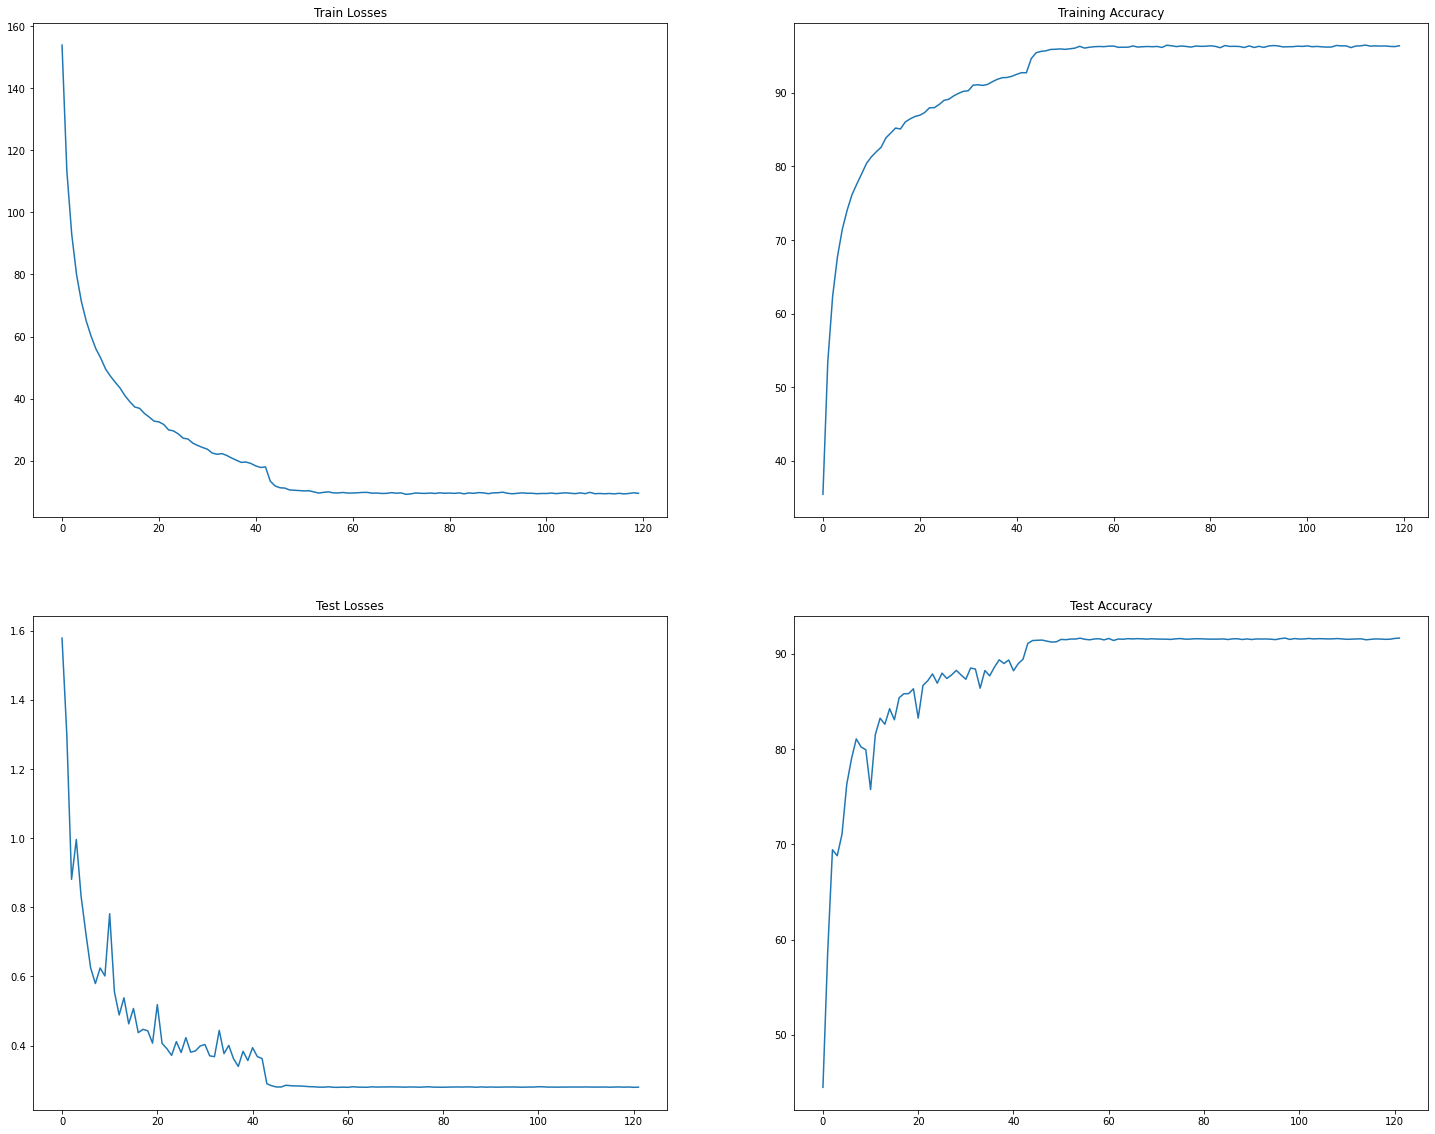

In [45]:
fig, axs = plt.subplots(2,2, figsize=(25,20))

axs[0,0].set_title('Train Losses')
axs[0,1].set_title('Training Accuracy')
axs[1,0].set_title('Test Losses')
axs[1,1].set_title('Test Accuracy')

axs[0,0].plot(train_losses)
axs[0,1].plot(train_acc)
axs[1,0].plot(test_losses)
axs[1,1].plot(test_acc)